In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
train_answers=pd.read_csv("train_answers.csv", sep=";",index_col=0)
test_answers=pd.read_csv("test_answers.csv", sep=";",index_col=0)

In [3]:
test_divs=['TEST Beetle Unseen Answers',
           'TEST Beetle Unseen Questions',
           'TEST sciEntsBank Unseen Answers',
           'TEST sciEntsBank Unseen Questions',
           'TEST sciEntsBank Unseen Domains']

## Explore Data

In [4]:
print(train_answers.columns)
train_answers.info()

Index(['dtset', 'qtype', 'stype', 'quest_id', 'question', 'ref_ans', 'st_answ',
       'id_st', 'st_ans_calif'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22167 entries, 0 to 22166
Data columns (total 9 columns):
dtset           22167 non-null object
qtype           17198 non-null object
stype           17198 non-null object
quest_id        22167 non-null object
question        22167 non-null object
ref_ans         22167 non-null object
st_answ         22167 non-null object
id_st           22167 non-null object
st_ans_calif    22167 non-null int64
dtypes: int64(1), object(8)
memory usage: 1.7+ MB


In [5]:
trn_smpl=train_answers.sample(1)
[list(trn_smpl[dat]) for dat in trn_smpl]

[['TRAIN Beetle'],
 ['Q_EXPLAIN_SPECIFIC'],
 ['EVALUATE'],
 ['BULB_C_VOLTAGE_EXPLAIN_WHY1'],
 ['Explain why you got a voltage reading of 1.5 for terminal 1 and the positive terminal.'],
 ['terminal 1 is not separated from the negative battery terminal'],
 ['Because they are not damaged.'],
 ['FaultFinding-BULB_C_VOLTAGE_EXPLAIN_WHY1.sbjb25-l1.qa164'],
 [0]]

In [6]:
tst_smpl=test_answers.sample(1)
[list(tst_smpl[dat]) for dat in tst_smpl]

[['TEST Beetle Unseen Questions'],
 ['Q_EXPLAIN_SPECIFIC'],
 ['EVALUATE'],
 ['HYBRID_BURNED_OUT_WHY_Q1'],
 ['Why do both bulbs B and C go out when bulb A is burned out?'],
 ['If bulb A burns out, there is no longer a closed path containing B, C and the battery'],
 ['they were on the same closed path'],
 ['SwitchesBulbsParallel-HYBRID_BURNED_OUT_WHY_Q1.sbjb32-l2.qa101'],
 [1]]

Baseline: 
http://homepages.inf.ed.ac.uk/mdzikovs/papers/dzikovska-naacl2012.pdf

# 3.2  Lexical similarity baseline
To   provide   a   higher   baseline   that   is   comparable   across   both   subsets   of   the   data,   we   built a  simple  decision  tree  classifier  using  the  Weka 3.6.2 implementation of C4.5 pruned decision trees (weka.classifiers.trees.J48  class),  with  default  parameters. As  features,  we  used  lexical  similarity scores computed by theText::Similarity package with default parameters. The code computes  four similarity  metrics  –  the  raw  number  ofoverlapping words, F1 score, Lesk score and cosine score.  We compared the learner response to the expected answer(s) and the question, resulting in eight total features (the four values indicated above for the comparison with the question and the highest of each value from the comparisons with each possible expected answer).

This baseline is based on the lexical overlap baseline used in RTE tasks (Bentivogli et al., 2009). However, we measured overlap with the question text in addition to the overlap with the expected answers. Students often repeat parts of the question in their answer and this needs to be taken into account to differentiate, for example, “partially correct incomplete” and “correct” answers.

In [7]:
trn_smpl

,dtset,qtype,stype,quest_id,question,ref_ans,st_answ,id_st,st_ans_calif
5407,TRAIN Beetle,Q_EXPLAIN_SPECIFIC,EVALUATE,BULB_C_VOLTAGE_EXPLAIN_WHY1,Explain why you got a voltage reading of 1.5 f...,terminal 1 is not separated from the negative ...,Because they are not damaged.,FaultFinding-BULB_C_VOLTAGE_EXPLAIN_WHY1.sbjb2...,0


# Preprocessing all data

In [8]:
complete_dataset=pd.concat([train_answers,test_answers], keys=['train', 'test'])# MultiIndexing Pandas

In [9]:
texts=np.array(complete_dataset["question"]+" "+complete_dataset["ref_ans"]+" "+complete_dataset["st_answ"])

## tf-idf matrix

In [10]:
count_vect = CountVectorizer()
txt_freqs = count_vect.fit_transform(texts)
txt_freqs.shape


(33763, 3931)

In [11]:
txt_freqs

<33763x3931 sparse matrix of type '<class 'numpy.int64'>'
	with 907433 stored elements in Compressed Sparse Row format>

In [12]:
tfidf_transformer = TfidfTransformer().fit(txt_freqs)
txt_tfidf=tfidf_transformer.transform(txt_freqs)

In [13]:
train_tfidf=txt_tfidf[complete_dataset.index.labels[0]==0,:]
train_tfidf_Y=train_answers["st_ans_calif"]
test_tfidf=txt_tfidf[complete_dataset.index.labels[0]==1,:]
test_tfidf_Y=test_answers["st_ans_calif"]

In [14]:
top_n=150
txt_freqs_sum= txt_freqs.toarray().sum(axis=0)
indices = np.argsort(txt_freqs_sum)[::-1]#np.argsort(vectorizer.idf_)[::-1]
features =count_vect.get_feature_names()# vectorizer.get_feature_names()
top_features = [[features[i],txt_freqs_sum[i]] for i in indices[:top_n]]
list(top_features)

[['the', 128985],
 ['and', 48205],
 ['is', 38743],
 ['in', 33215],
 ['of', 31076],
 ['terminal', 30816],
 ['to', 28797],
 ['bulb', 25137],
 ['are', 20014],
 ['why', 18688],
 ['path', 16850],
 ['battery', 16727],
 ['you', 15946],
 ['water', 15856],
 ['voltage', 13473],
 ['not', 13384],
 ['it', 13204],
 ['gap', 12946],
 ['was', 12880],
 ['closed', 12180],
 ['explain', 12001],
 ['on', 10622],
 ['there', 10506],
 ['when', 10017],
 ['same', 9967],
 ['positive', 9940],
 ['for', 9537],
 ['switch', 9513],
 ['what', 9280],
 ['that', 9012],
 ['because', 8761],
 ['with', 8446],
 ['out', 8393],
 ['terminals', 8251],
 ['circuit', 8022],
 ['does', 8000],
 ['reading', 7517],
 ['electrical', 7179],
 ['connected', 7145],
 ['one', 6281],
 ['or', 6146],
 ['if', 6121],
 ['got', 6121],
 ['between', 6011],
 ['open', 5672],
 ['different', 5651],
 ['no', 5602],
 ['from', 5334],
 ['by', 5193],
 ['states', 5162],
 ['will', 5090],
 ['bulbs', 5054],
 ['be', 4915],
 ['she', 4895],
 ['how', 4803],
 ['they', 4786],


# Basic Clasifiers

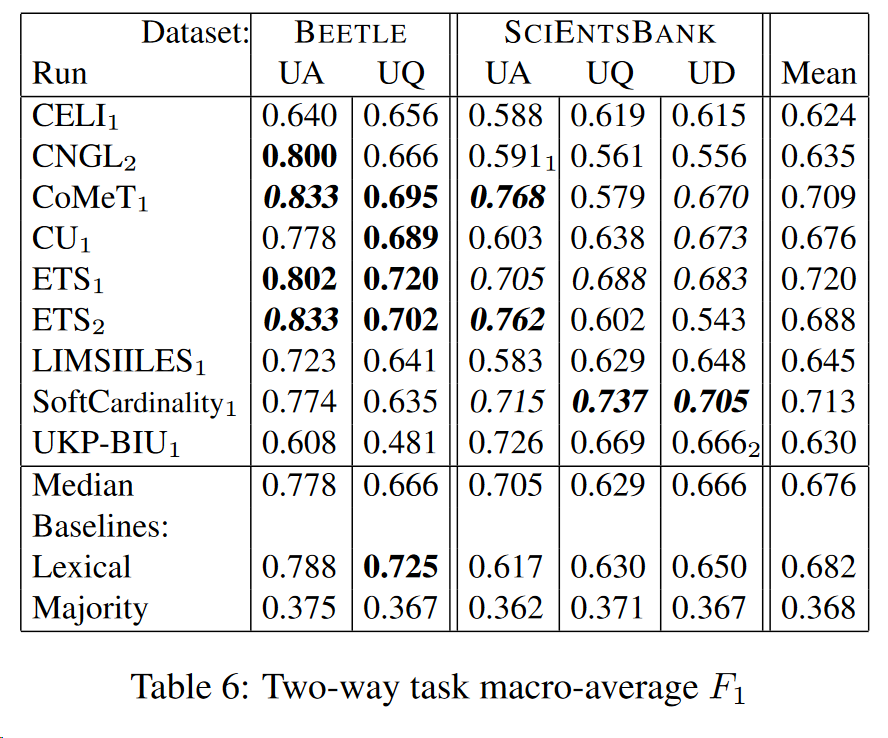

## 1. Naïve Bayes

In [15]:
gnb = GaussianNB()
predictor_GaussianNB= gnb.fit(train_tfidf.toarray(), train_tfidf_Y)
y_pred_GaussianNB= predictor_GaussianNB.predict(train_tfidf.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (train_tfidf.shape[0],(train_tfidf_Y != y_pred_GaussianNB).sum()))

Number of mislabeled points out of a total 22167 points : 9394


In [16]:
print (f1_score(train_tfidf_Y, y_pred_GaussianNB, average='weighted'))

0.5282955841529756


In [17]:
y_test_GaussianNB = predictor_GaussianNB.predict(test_tfidf.toarray())
print (f1_score(test_tfidf_Y, y_test_GaussianNB, average='weighted'))

0.5371742724126949


In [18]:
test_divs=['TEST Beetle Unseen Answers',
           'TEST Beetle Unseen Questions',
           'TEST sciEntsBank Unseen Answers',
           'TEST sciEntsBank Unseen Questions',
           'TEST sciEntsBank Unseen Domains']

In [19]:
for test_class in test_divs:
    y_test_GaussianNB_class = predictor_GaussianNB.predict(test_tfidf.toarray()[test_answers["dtset"]==test_class])
    print(test_class, f1_score(test_tfidf_Y[test_answers["dtset"]==test_class], y_test_GaussianNB_class, average='weighted'))
    print(pd.crosstab(columns=test_tfidf_Y[test_answers["dtset"]==test_class], index=y_test_GaussianNB_class,margins=True))
    print("***********************************************************************")

TEST Beetle Unseen Answers 0.42554311959521074
st_ans_calif     0    1   All
row_0                        
0              195   16   211
1              911  740  1651
All           1106  756  1862
***********************************************************************
TEST Beetle Unseen Questions 0.4752690184528084
st_ans_calif     0     1   All
row_0                         
0              420   261   681
1             1570  1648  3218
All           1990  1909  3899
***********************************************************************
TEST sciEntsBank Unseen Answers 0.46807920454060514
st_ans_calif    0    1  All
row_0                      
0              84   47  131
1             223  186  409
All           307  233  540
***********************************************************************
TEST sciEntsBank Unseen Questions 0.5168486617535006
st_ans_calif    0    1  All
row_0                      
0             224  149  373
1             208  152  360
All           432  301  733

## 2. Logistic Regression

In [20]:
LogReg = LogisticRegression(solver='lbfgs', n_jobs=-1)
predictor_LogReg= LogReg.fit(train_tfidf.toarray(), train_tfidf_Y)
y_pred_LogReg= predictor_LogReg.predict(train_tfidf.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (train_tfidf.shape[0],(train_tfidf_Y != y_pred_LogReg).sum()))

Number of mislabeled points out of a total 22167 points : 5217


In [21]:
print (f1_score(train_tfidf_Y, y_pred_LogReg, average='weighted'))

0.7621680715554362


In [22]:
y_test_LogReg = predictor_LogReg.predict(test_tfidf.toarray())
print (f1_score(test_tfidf_Y, y_test_LogReg, average='weighted'))

0.5605262170288648


In [23]:
for test_class in test_divs:
    y_test_LogReg_class = predictor_LogReg.predict(test_tfidf.toarray()[test_answers["dtset"]==test_class])
    print(test_class, f1_score(test_tfidf_Y[test_answers["dtset"]==test_class], y_test_LogReg_class, average='weighted'))
    print(pd.crosstab(columns=test_tfidf_Y[test_answers["dtset"]==test_class], index=y_test_LogReg_class,margins=True))
    print("***********************************************************************")

TEST Beetle Unseen Answers 0.7358858706223297
st_ans_calif     0    1   All
row_0                        
0              893  275  1168
1              213  481   694
All           1106  756  1862
***********************************************************************
TEST Beetle Unseen Questions 0.5732755925260097
st_ans_calif     0     1   All
row_0                         
0             1309   971  2280
1              681   938  1619
All           1990  1909  3899
***********************************************************************
TEST sciEntsBank Unseen Answers 0.6013040695016004
st_ans_calif    0    1  All
row_0                      
0             233  135  368
1              74   98  172
All           307  233  540
***********************************************************************
TEST sciEntsBank Unseen Questions 0.5061535949562466
st_ans_calif    0    1  All
row_0                      
0             297  215  512
1             135   86  221
All           432  301  733
*

## 3. FeedForward Fully conected ANN

In [24]:
ANN_clf= MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(2000,200), random_state=1)
predictor_ANN_clf= ANN_clf.fit(train_tfidf.toarray(), train_tfidf_Y)
y_pred_ANN_clf= predictor_ANN_clf.predict(train_tfidf.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (train_tfidf.shape[0],(train_tfidf_Y != y_pred_ANN_clf).sum()))

Number of mislabeled points out of a total 22167 points : 5217


In [25]:
print (f1_score(train_tfidf_Y, y_pred_ANN_clf, average='weighted'))

0.9220340771190451


In [26]:
y_test_LogReg = predictor_LogReg.predict(test_tfidf.toarray())
print (f1_score(test_tfidf_Y, y_test_LogReg, average='weighted'))

0.5605262170288648


In [27]:
for test_class in test_divs:
    y_test_LogReg_class = predictor_LogReg.predict(test_tfidf.toarray()[test_answers["dtset"]==test_class])
    print(test_class, f1_score(test_tfidf_Y[test_answers["dtset"]==test_class], y_test_LogReg_class, average='weighted'))
    print(pd.crosstab(columns=test_tfidf_Y[test_answers["dtset"]==test_class], index=y_test_LogReg_class,margins=True))
    print("***********************************************************************")

TEST Beetle Unseen Answers 0.7358858706223297
st_ans_calif     0    1   All
row_0                        
0              893  275  1168
1              213  481   694
All           1106  756  1862
***********************************************************************
TEST Beetle Unseen Questions 0.5732755925260097
st_ans_calif     0     1   All
row_0                         
0             1309   971  2280
1              681   938  1619
All           1990  1909  3899
***********************************************************************
TEST sciEntsBank Unseen Answers 0.6013040695016004
st_ans_calif    0    1  All
row_0                      
0             233  135  368
1              74   98  172
All           307  233  540
***********************************************************************
TEST sciEntsBank Unseen Questions 0.5061535949562466
st_ans_calif    0    1  All
row_0                      
0             297  215  512
1             135   86  221
All           432  301  733
*

# SKlearn Classifier Comparisson

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [29]:
h = .02  # step size in the mesh

names = [
    "Nearest Neighbors", 
#     "Linear SVM", 
    "RBF SVM", 
#     "Gaussian Process",
    "Decision Tree", 
    "Random Forest", 
    "Neural Net", 
    "AdaBoost",
    "Naive Bayes", 
    "QDA"]

classifiers = [
    KNeighborsClassifier(3,n_jobs=-1),
#     SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [30]:
train_scores=[]
clasif_scores=[]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name)
    clf.fit(train_tfidf.toarray(), train_tfidf_Y)
    prediction=clf.predict(train_tfidf.toarray())
    score = f1_score(train_tfidf_Y, prediction, average='weighted')
    train_scores.append(score)
    print("Train Clasif:",score)
    print("Number of mislabeled points out of a total %d points : %d" % (train_tfidf.shape[0],(train_tfidf_Y != prediction).sum()))
    test_scores=[]
    for test_class in test_divs:
        y_test_clf_class = clf.predict(test_tfidf.toarray()[test_answers["dtset"]==test_class])
        y_test_clf_class_f1=f1_score(test_tfidf_Y[test_answers["dtset"]==test_class], y_test_clf_class, average='weighted')
        test_scores.append(y_test_clf_class_f1)
        print(test_class,y_test_clf_class_f1)
        print(pd.crosstab(columns=test_tfidf_Y[test_answers["dtset"]==test_class], index=y_test_clf_class,margins=True))
        print("-----------------------------------------------------")
    clasif_scores.append(test_scores)
    print("***********************************************************************************************")

Nearest Neighbors
Train Clasif: 0.9318645431748587
Number of mislabeled points out of a total 22167 points : 1512
TEST Beetle Unseen Answers 0.787112733398022
st_ans_calif     0    1   All
row_0                        
0              865  158  1023
1              241  598   839
All           1106  756  1862
-----------------------------------------------------
TEST Beetle Unseen Questions 0.5838420728294598
st_ans_calif     0     1   All
row_0                         
0              934   543  1477
1             1056  1366  2422
All           1990  1909  3899
-----------------------------------------------------
TEST sciEntsBank Unseen Answers 0.7308712121212121
st_ans_calif    0    1  All
row_0                      
0             248   85  333
1              59  148  207
All           307  233  540
-----------------------------------------------------
TEST sciEntsBank Unseen Questions 0.5620836646701345
st_ans_calif    0    1  All
row_0                      
0             264  154  41

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TEST sciEntsBank Unseen Domains 0.42557052921233784
st_ans_calif     0     1   All
row_0                         
0             2645  1917  4562
All           2645  1917  4562
-----------------------------------------------------
***********************************************************************************************
Decision Tree
Train Clasif: 0.6773214868318811
Number of mislabeled points out of a total 22167 points : 6991
TEST Beetle Unseen Answers 0.6973574646975925
st_ans_calif     0    1   All
row_0                        
0              765  227   992
1              341  529   870
All           1106  756  1862
-----------------------------------------------------
TEST Beetle Unseen Questions 0.5710337022442812
st_ans_calif     0     1   All
row_0                         
0             1422  1072  2494
1              568   837  1405
All           1990  1909  3899
-----------------------------------------------------
TEST sciEntsBank Unseen Answers 0.4121255848528576
st_ans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TEST sciEntsBank Unseen Questions 0.4370866976210412
st_ans_calif    0    1  All
row_0                      
0             432  301  733
All           432  301  733
-----------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TEST sciEntsBank Unseen Domains 0.42557052921233784
st_ans_calif     0     1   All
row_0                         
0             2645  1917  4562
All           2645  1917  4562
-----------------------------------------------------
***********************************************************************************************
Random Forest
Train Clasif: 0.4286608916972399
Number of mislabeled points out of a total 22167 points : 9287
TEST Beetle Unseen Answers 0.44268690594410554


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


st_ans_calif     0    1   All
row_0                        
0             1106  756  1862
All           1106  756  1862
-----------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TEST Beetle Unseen Questions 0.34493825260348854
st_ans_calif     0     1   All
row_0                         
0             1990  1909  3899
All           1990  1909  3899
-----------------------------------------------------
TEST sciEntsBank Unseen Answers 0.42456035439407597
st_ans_calif    0    1  All
row_0                      
0             307  230  537
1               0    3    3
All           307  233  540
-----------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TEST sciEntsBank Unseen Questions 0.4370866976210412
st_ans_calif    0    1  All
row_0                      
0             432  301  733
All           432  301  733
-----------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TEST sciEntsBank Unseen Domains 0.42557052921233784
st_ans_calif     0     1   All
row_0                         
0             2645  1917  4562
All           2645  1917  4562
-----------------------------------------------------
***********************************************************************************************
Neural Net
Train Clasif: 0.6998880790486987
Number of mislabeled points out of a total 22167 points : 6496
TEST Beetle Unseen Answers 0.6946646685458853
st_ans_calif     0    1   All
row_0                        
0              856  314  1170
1              250  442   692
All           1106  756  1862
-----------------------------------------------------
TEST Beetle Unseen Questions 0.6093711864336417
st_ans_calif     0     1   All
row_0                         
0             1232   765  1997
1              758  1144  1902
All           1990  1909  3899
-----------------------------------------------------
TEST sciEntsBank Unseen Answers 0.5481310242190628
st_ans_ca

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Train Clasif: 0.6601585895406393
Number of mislabeled points out of a total 22167 points : 7224
TEST Beetle Unseen Answers 0.5295219549089518
st_ans_calif     0    1   All
row_0                        
0              336   38   374
1              770  718  1488
All           1106  756  1862
-----------------------------------------------------
TEST Beetle Unseen Questions 0.5555733772931251
st_ans_calif     0     1   All
row_0                         
0             1107   850  1957
1              883  1059  1942
All           1990  1909  3899
-----------------------------------------------------
TEST sciEntsBank Unseen Answers 0.5923759350483488
st_ans_calif    0    1  All
row_0                      
0             198  111  309
1             109  122  231
All           307  233  540
-----------------------------------------------------
TEST sciEntsBank Unseen Questions 0.4903922252715478
st_ans_calif    0    1  All
row_0                      
0             280  213  493
1             1

    primera_ronda=[
    [0.787112733398022,0.5838420728294598,0.7308712121212121,0.5620836646701345,0.4914699221309699],
    [0.5859916188801279,0.4530869571407395,0.44167411724716754,0.4370866976210412,0.42557052921233784],
    [0.8196234822458234,0.63706818920818,0.6644979662681494,0.5702569621674781,0.42557052921233784]]

In [31]:
clasif_scores

[[0.787112733398022,
  0.5838420728294598,
  0.7308712121212121,
  0.5620836646701345,
  0.4914699221309699],
 [0.8196234822458234,
  0.63706818920818,
  0.6644979662681494,
  0.5702569621674781,
  0.42557052921233784],
 [0.6973574646975925,
  0.5710337022442812,
  0.4121255848528576,
  0.4370866976210412,
  0.42557052921233784],
 [0.44268690594410554,
  0.34493825260348854,
  0.42456035439407597,
  0.4370866976210412,
  0.42557052921233784],
 [0.6946646685458853,
  0.6093711864336417,
  0.5481310242190628,
  0.4624841208529302,
  0.42536677942670353],
 [0.7248791116813923,
  0.6067536739145571,
  0.5678998521892842,
  0.4695104722143299,
  0.44436224934155294],
 [0.42554311959521074,
  0.4752690184528084,
  0.46807920454060514,
  0.5168486617535006,
  0.5856861625694988],
 [0.5295219549089518,
  0.5555733772931251,
  0.5923759350483488,
  0.4903922252715478,
  0.5558032269958835]]

In [32]:
results=pd.DataFrame(np.array(clasif_scores), columns=test_divs, index=names)#["KNN","Linear_SVM","RBF_SVM"])
# results["mean"]=results.mean(axis=1)
# results["train performance"]=train_scores

In [35]:
results

,TEST Beetle Unseen Answers,TEST Beetle Unseen Questions,TEST sciEntsBank Unseen Answers,TEST sciEntsBank Unseen Questions,TEST sciEntsBank Unseen Domains
Nearest Neighbors,0.787113,0.583842,0.730871,0.562084,0.491470
RBF SVM,0.819623,0.637068,0.664498,0.570257,0.425571
Decision Tree,0.697357,0.571034,0.412126,0.437087,0.425571
Random Forest,0.442687,0.344938,0.424560,0.437087,0.425571
Neural Net,0.694665,0.609371,0.548131,0.462484,0.425367
AdaBoost,0.724879,0.606754,0.567900,0.469510,0.444362
Naive Bayes,0.425543,0.475269,0.468079,0.516849,0.585686
QDA,0.529522,0.555573,0.592376,0.490392,0.555803


In [33]:
results.to_csv("primeros_resultados.csv")

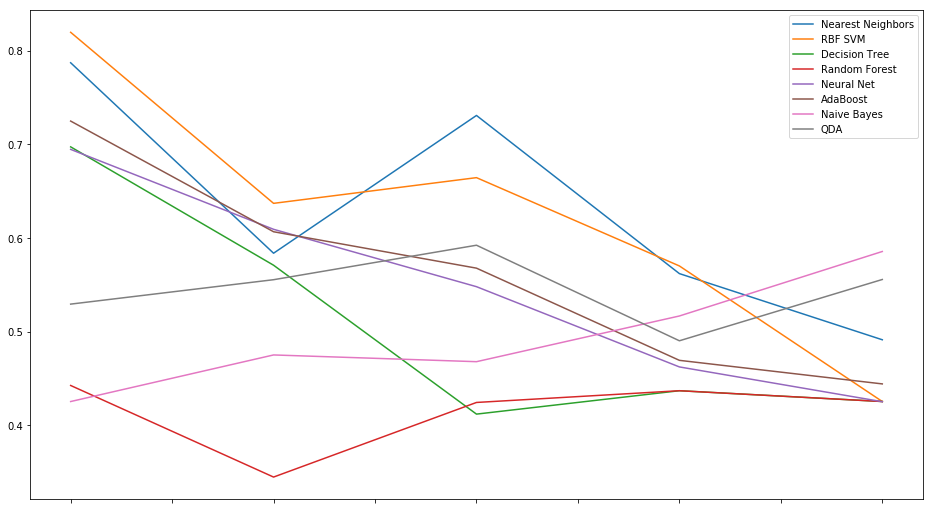

In [34]:
results.T.plot(figsize=(16,9))
# plt.line()